# Introduction to Time Series Analysis in Python - Part 5

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

import datetime

## Putting It All Together

### A Dog on a Leash? (Part 1)
The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in \$/gallon, by 7.25, which converts it to \$/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from Quandl (https://blog.quandl.com/api-for-futures-data).

In [5]:
HO = pd.read_csv('../datasets/stock/CME_HO1.csv', index_col=0)
HO.index = pd.to_datetime(HO.index)
HO.head()

,Close
Date,
1991-01-08,0.7430
1991-01-07,0.7617
1991-01-04,0.6830
1991-01-03,0.7024
1991-01-02,0.7330


In [7]:
NG = pd.read_csv('../datasets/stock/CME_NG1.csv', index_col=0)
NG.index = pd.to_datetime(NG.index)
NG.head()

,Close
Date,
2005-12-30,11.225
2005-12-29,11.223
2005-12-28,11.431
2005-12-27,11.022
2005-12-23,12.283


In [10]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small');

In [11]:
# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k');

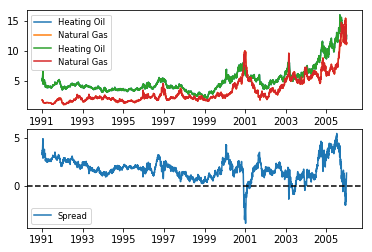

In [12]:
plt.show()

### A Dog on a Leash? (Part 2)
To verify that HO and NG are cointegrated, First apply the Dickey-Fuller test to HO and NG separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG.

In [14]:
# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

The p-value for the ADF test on HO is  0.0198310280716
The p-value for the ADF test on NG is  0.00454728495654


In [15]:
# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on the spread is  0.000118870518274


### Are Bitcoin and Ethereum Cointegrated?
Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,−1). In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

In [190]:
BTC = pd.read_csv('../datasets/stock/BTC.csv', index_col=0, parse_dates=True)
BTC.head()

,Price
Date,
2015-09-29,237.770330
2015-09-30,237.430748
2015-10-01,238.550000
2015-10-02,238.034550
2015-10-03,240.120000


In [191]:
ETH = pd.read_csv('../datasets/stock/ETH.csv', index_col=0, parse_dates=True)
ETH.head()

,Price
Date,
2015-07-30,0.0
2015-07-31,0.0
2015-08-01,0.0
2015-08-02,0.0
2015-08-03,0.0


In [192]:
BTC.index, ETH.index

(DatetimeIndex(['2015-09-29', '2015-09-30', '2015-10-01', '2015-10-02',
                '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06',
                '2015-10-07', '2015-10-08',
                ...
                '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21',
                '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25',
                '2018-06-26', '2018-06-27'],
               dtype='datetime64[ns]', name='Date', length=1003, freq=None),
 DatetimeIndex(['2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02',
                '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
                '2015-08-07', '2015-08-08',
                ...
                '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21',
                '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25',
                '2018-03-26', '2018-03-27'],
               dtype='datetime64[ns]', name='Date', length=972, freq=None))

In [193]:
BTC = BTC.loc['2015-09-29':'2018-03-27']
ETH = ETH.loc['2015-09-29':'2018-03-27']

In [194]:
ETH.size, BTC.size

(911, 911)

In [201]:
# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC.values, ETH.values).fit()

In [202]:
# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b*ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  2.75482305345e-06


### Is Temperature a Random Walk (with Drift)?
An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame temp_NY contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA here(https://www.ncdc.noaa.gov/cdo-web/search)). Plot the data and test whether it follows a random walk (with drift).

In [10]:
temp_NY = pd.read_csv('../datasets/stock/temp_NY.csv', index_col=0)
temp_NY.head()

,TAVG
DATE,
1870,53.6
1871,51.3
1872,51.3
1873,50.8
1874,51.2


In [11]:
# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

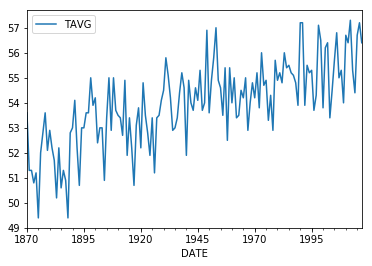

In [12]:
# Plot average temperatures
temp_NY.plot()
plt.show()

In [13]:
# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  0.611128359558


### Getting "Warmed" Up: Look at Autocorrelations
Since the temperature series, temp_NY, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

In [26]:
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

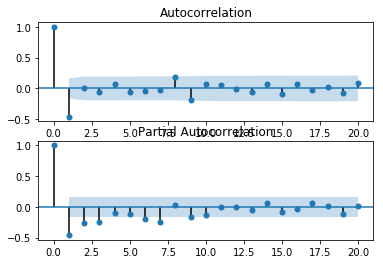

In [29]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

### Which ARMA Model is Best?
Fit the temperature data to an AR(1), AR(2), MA(1), and ARMA(1,1) and see which model is the best fit, using the AIC criterion.

In [31]:
# Fit the data to an AR(1) model and print AIC:
mod = ARMA(chg_temp, order=(1,0))
res = mod.fit()
print("The AIC for an AR(1) is: ", res.aic)

The AIC for an AR(1) is:  512.4799061602608


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [32]:
# Fit the data to an AR(2) model and print AIC:
mod = ARMA(chg_temp, order=(2,0))
res = mod.fit()
print("The AIC for an AR(2) is: ", res.aic)

The AIC for an AR(2) is:  503.61600304809735


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [33]:
# Fit the data to an MA(1) model and print AIC:
mod = ARMA(chg_temp, order=(0,1))
res = mod.fit()
print("The AIC for an MA(1) is: ", res.aic)

The AIC for an MA(1) is:  471.06677538765825


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [34]:
# Fit the data to an ARMA(1,1) model and print AIC:
mod = ARMA(chg_temp, order=(1,1))
res = mod.fit()
print("The AIC for an ARMA(1,1) is: ", res.aic)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


The AIC for an ARMA(1,1) is:  470.6433825677371


### Don't Throw Out That Winter Coat Yet
Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. You will use the ARIMA module on the temperature data, pre-loaded in the DataFrame temp_NY, but the forecast would be the same as using the ARMA module on changes in temperature, and then using cumulative sums of these changes to get the temperature.

In [66]:
# Forecast interest rates using an AR(1) model
mod = ARIMA(temp_NY, order=(1,1,1))
res = mod.fit()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


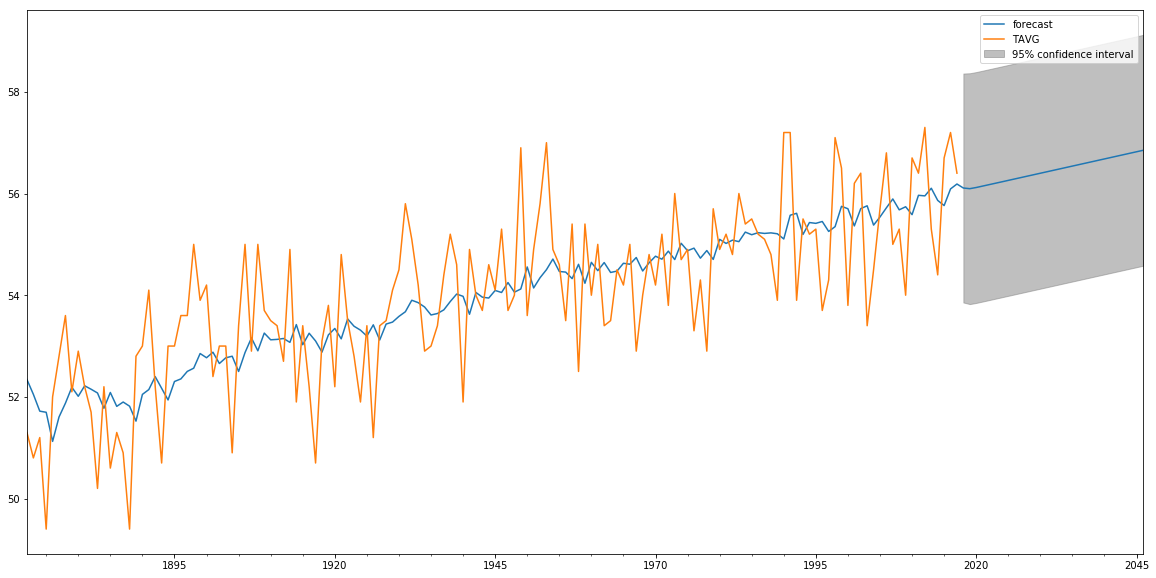

In [67]:
# Plot the original series and the forecasted series
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
res.plot_predict(start='1872-01-01', end='2046-01-01', ax=ax)
plt.show()

### Advanced Topics
* GARCH Models
* Nonlinear Models
* Multivariate Time Series Models
* Regime Switching Models
* State Space Models and Kalman Filtering